# **Imports**

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# Loading data

In [2]:
file_path = 'ass3.pickle'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['train'].iloc[:,:-1].values)
y_train = np.array(data['train'].iloc[:,-1:].values)

X_val = np.array(data['dev'].iloc[:,:-1].values)
y_val = np.array(data['dev'].iloc[:,-1:].values)

X_test = np.array(data['test'].iloc[:,:-1].values)
y_test = np.array(data['test'].iloc[:,-1:].values)



# Preliminary Data Analysis

In [3]:
print(f"size of train: {len(data['train'])}")
print(f"size of test: {len(data['test'])}")
print(f"size of dev: {len(data['dev'])}")

size of train: 12384
size of test: 4128
size of dev: 4128


In [26]:
# Convert data to pandas dataframes
train_df = pd.DataFrame(data['train'])
print("Number of columns:", train_df.shape[1])
print("\nDescriptive statistics:")
print(train_df.describe())

Number of columns: 9

Descriptive statistics:
                 f0            f1            f2            f3            f4  \
count  12210.000000  12244.000000  12226.000000  12228.000000  12215.000000   
mean       3.872771     28.630595      5.420978      1.096626   1426.830618   
std        1.919183     12.566127      2.382548      0.471398   1103.528284   
min        0.499900      1.000000      0.846154      0.500000      3.000000   
25%        2.555600     18.000000      4.430232      1.006386    786.000000   
50%        3.534100     29.000000      5.218429      1.049202   1170.000000   
75%        4.745975     37.000000      6.043349      1.099202   1739.000000   
max       15.000100     52.000000    132.533333     34.066667  28566.000000   

                 f5            f6            f7        target  
count  12242.000000  12233.000000  12236.000000  12384.000000  
mean       3.144714     35.626833   -119.561040      2.066362  
std       13.440452      2.133539      1.996646   

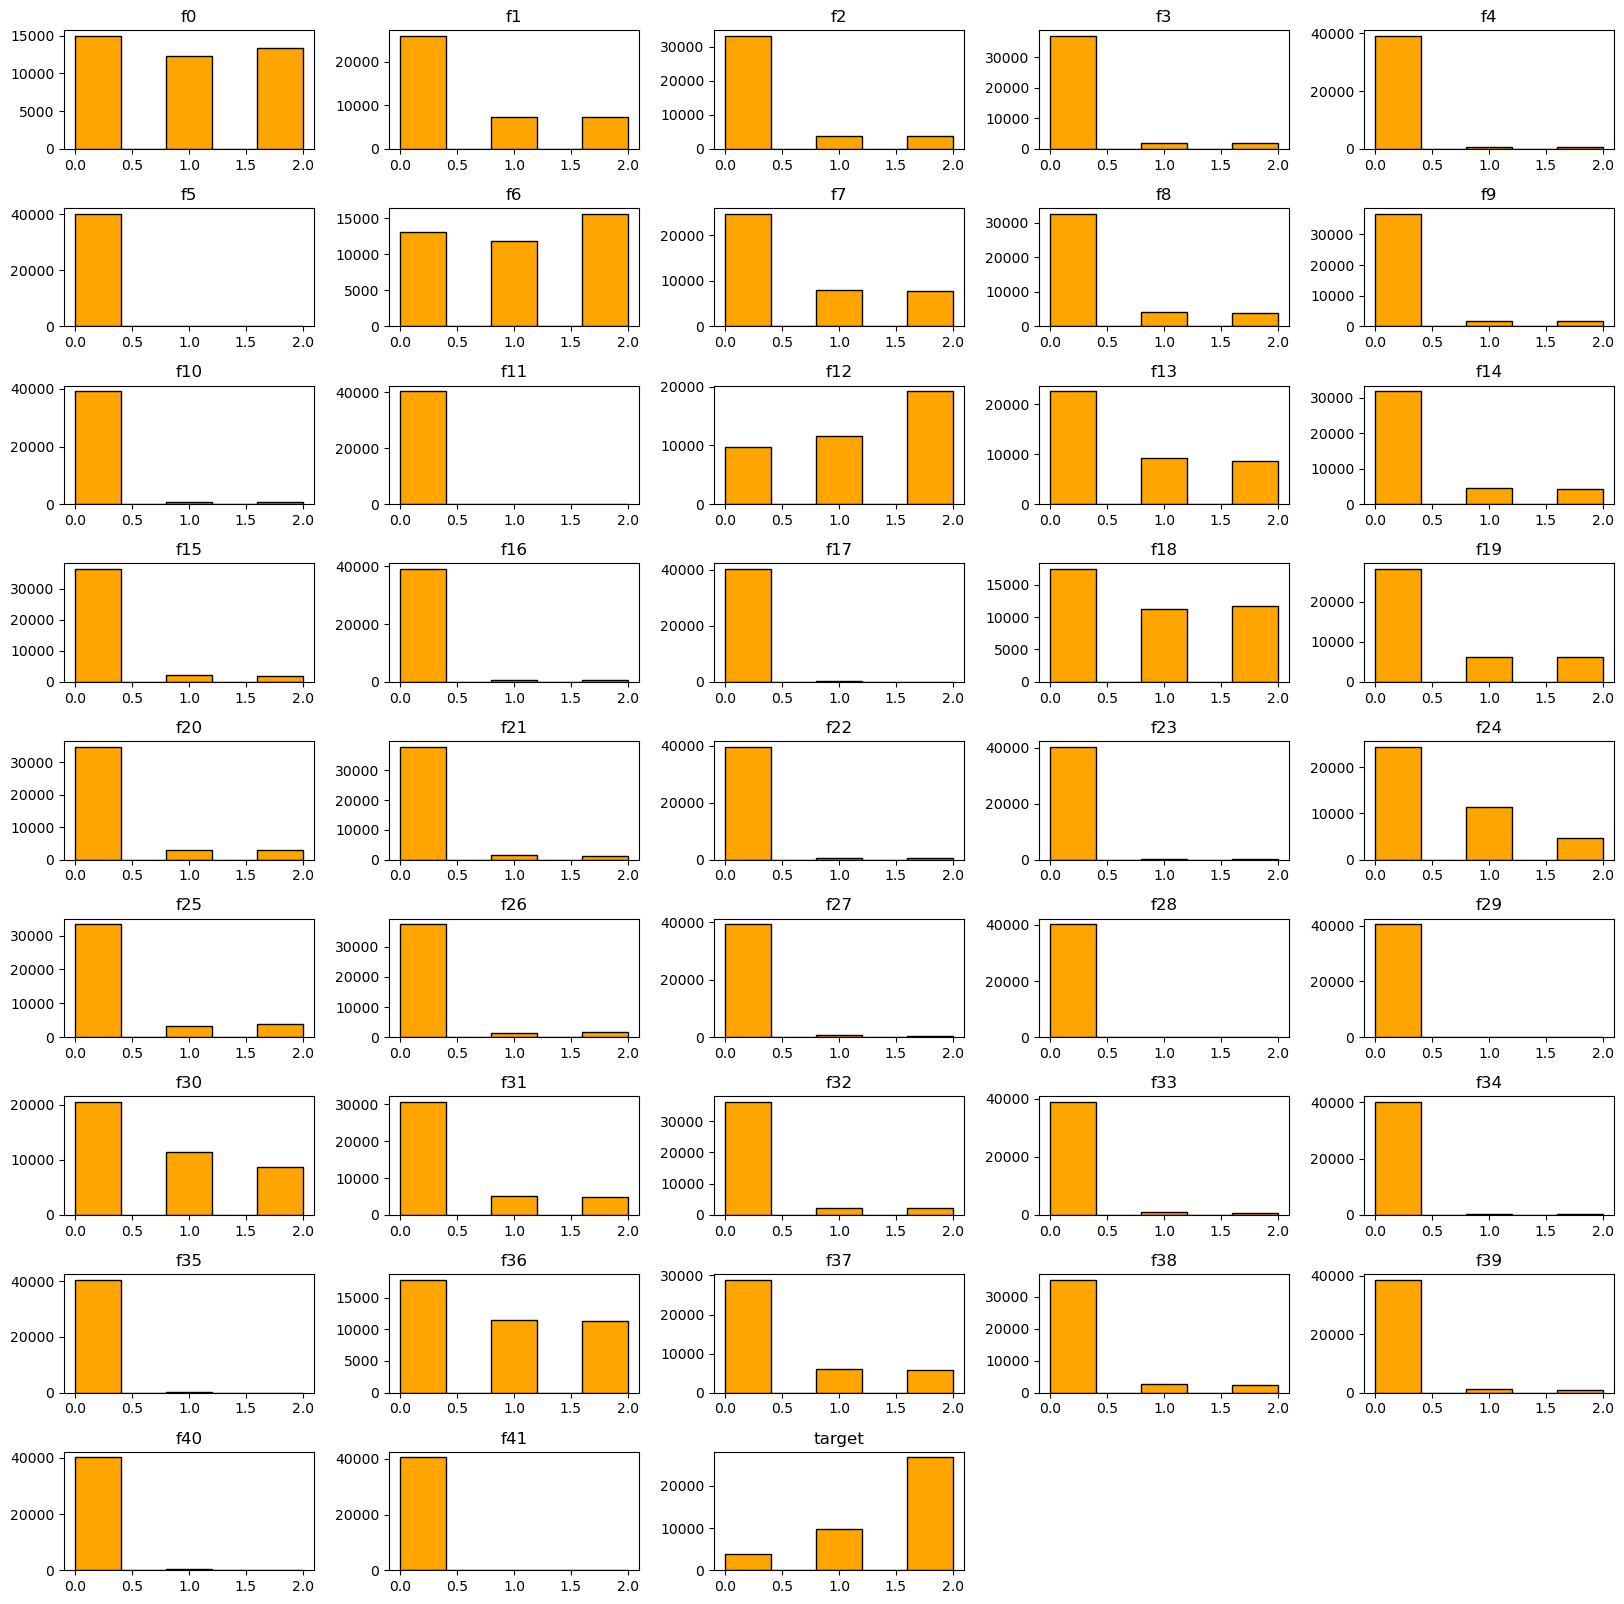

In [39]:
# Convert data to pandas dataframes
train_df = pd.DataFrame(data['train'])
print("Number of columns:", train_df.shape[1])
print("\nDescriptive statistics:")
print(train_df.describe())

# Explore the distribution of features
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(20, 20), gridspec_kw={"hspace": 0.5, "wspace": 0.3})
axs = axs.ravel()
for i, column in enumerate(train_df.columns):
    axs[i].hist(train_df[column], bins=5, edgecolor='black', color='orange')
    axs[i].set_title(column)
    
axs[-1].set_visible(False)
axs[-2].set_visible(False)
plt.show()

in the distribution of features we can see that many are almost always 0 and barely any other values.

if computation gets too rought, we could probably shrink the dimention of our data using PCA without losing much.

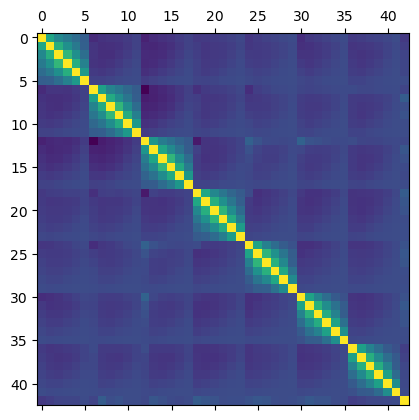

In [40]:
# Look for correlations between features
corr_matrix = train_df.corr()
plt.matshow(corr_matrix)
plt.show()


heatmap showing correlation between different features




# Model Selection

In [41]:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

here we concatenate the train and valdiation sets, and creates and PredefinedSplit object so that the grid search knows which examples to use for the train and which examples for the validation.


In [42]:
models = [
          ('RandomForest', RandomForestClassifier()), 
          ('AdaBoost', AdaBoostClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('XGB', XGBClassifier()),
          ('SVC', SVC())
         ]

Here we defined our algorithms (models) that we will check and some basic hyperparameters for each



In [43]:
param_grid = {
    'RandomForest':{
        'n_estimators': [50,100,300],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt',15]
    },

    'AdaBoost':{
        'n_estimators': [50, 100, 300],
        'learning_rate':[0.1, 1.0, 2.0],
        'algorithm':['SAMME', 'SAMME.R']
    },

    'KNN':{
        'n_neighbors': [1,5,10],
        'p': [1,2],
        'leaf_size': [20,30,40] 
        
    },

    'XGB':{
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.3, 1.0],
    'max_depth': [6, 10]
    },

    'SVC':{
    'degree': [3, 7],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0]
    }
}

here we defined param grid dictionary, the keys are the algorithm name, and the value are dictionary where the keys are the parameter name, and the value are the inputs to those parameters

In [44]:
best_f1_weighted_scores = []
best_accuracy_scores = []
model_names = [model[0] for model in models]

for model in models:
    grid_search = GridSearchCV(estimator=model[1], param_grid=param_grid[model[0]], cv=predefined_split,
                              scoring=['f1_weighted','accuracy'], refit = 'accuracy')
    grid_search.fit(X_train_val, y_train_val)
    cv_results = grid_search.cv_results_
    best_f1_weighted_score = max(cv_results["mean_test_f1_weighted"])
    best_accuracy_score = max(cv_results["mean_test_accuracy"])
    best_f1_weighted_scores.append(best_f1_weighted_score)
    best_accuracy_scores.append(best_accuracy_score)
    print(f"Finish with {model[0]}")

Finish with RandomForest
Finish with AdaBoost
Finish with KNN
Finish with XGB
Finish with SVC


we chose 2 matrics:

1.   accuracy score: $\frac{1}{n} \sum_{i=1}^{n} 1(y_i = \hat{y}_i)$
where n is the samples size, $y_i$ is the correct label and $\hat{y}_1$ is the model prediction

2.   f1 weighted score: its uses the precision and recall, considering the appearnce of each class in the train set. 

  Precision = $\frac{{TP}}{{TP + FP}}$, 
  Recall = $\frac{{TP}}{{TP + FN}}$ \\
  
  F1 = $2 \cdot \frac{{\text{{Precision}} \cdot \text{{Recall}}}}{{\text{{Precision}} + \text{{Recall}}}}$ \\

  and f1 weighted score (our formula) = $\frac{{\sum_{i \in \text{{classes}}}(F1_{\text{{class}}_i} \cdot \text{{count}}_{\text{{class}}_i})}}{{\sum_{i \in \text{{classes}}}\text{{count}}_{\text{{class}}_i}}}$

we used those formula because we wanted to check the accuracy of the model, conisdering the fact that its unbalace. 


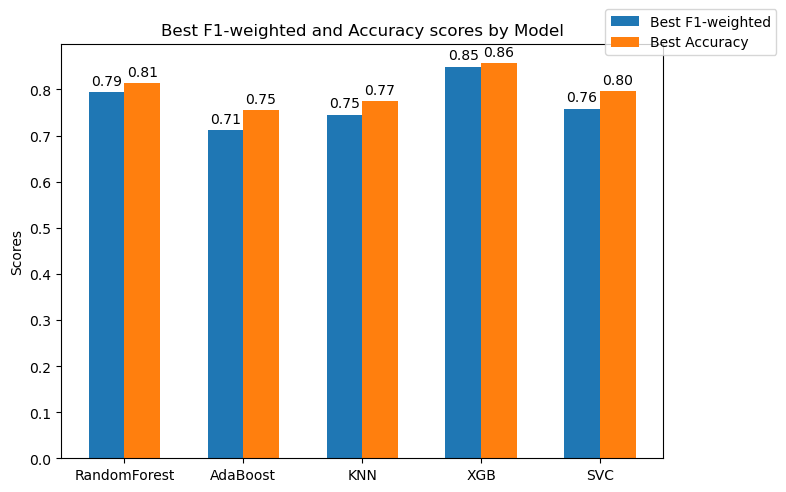

In [45]:
x = np.arange(len(model_names))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_f1_weighted_scores, width, label='Best F1-weighted')
rects2 = ax.bar(x + width/2, best_accuracy_scores, width, label='Best Accuracy')

ax.set_ylabel('Scores')
ax.set_title('Best F1-weighted and Accuracy scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

here we checked 5 different models, and we can see that the best algorithm for our problem is the XGBClassifier.
We'll proceed with doing forther testing to see if we can get an even better model with XGB.

# Pre-Processing
We will do some preprocess to our data, and check if its change the behavior of our model (if it will increase the performance or reduce it)

### Select K Best features
We'll attempt to reduce the amount of features of our samples. This approach might work since we could see in the Preliminary Data Analysis that a lot of the features seemed to be almost always only a single value. 

In [46]:
k_options = [24,36,42]
dict_of_parameters_value = {
    'n_estimators': [300, 500],
    'learning_rate': [0.2, 0.3],
    'max_depth': [6, 10]
    }
best_f1_weighted_scores = []
best_accuracy_scores = []
for k in k_options:
    grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                              scoring=['f1_weighted','accuracy'], refit = 'accuracy')

    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train_val, y_train_val.ravel())
    X_train_val_selected = selector.transform(X_train_val)
    X_test_selected = selector.transform(X_test)
    grid_search.fit(X_train_val_selected, y_train_val)
    cv_results = grid_search.cv_results_
    best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
    best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
    best_f1_score_params = cv_results['params'][best_f1_score_idx]
    best_acc_score_params = cv_results['params'][best_acc_score_idx]
    best_f1_weighted_scores.append((cv_results["mean_test_f1_weighted"][best_f1_score_idx], best_f1_score_params))
    best_accuracy_scores.append((cv_results["mean_test_accuracy"][best_acc_score_idx],best_acc_score_params))
    print(f"Finish with k={k}")

Finish with k=24
Finish with k=36
Finish with k=42


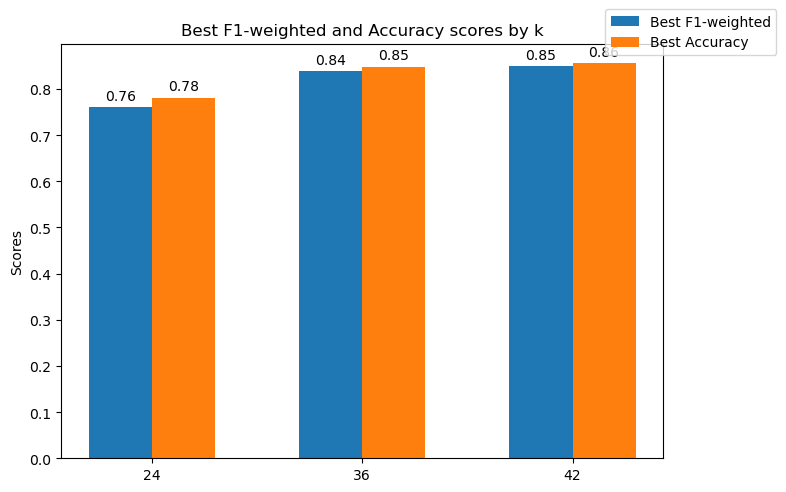

Best parameters for f1 score: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300}
Best parameters for accuracy score: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}


In [47]:
best_f1_scores = [score[0] for score in best_f1_weighted_scores]
best_acc_scores = [score[0] for score in best_accuracy_scores]
best_f1_params = [score[1] for score in best_f1_weighted_scores]
best_acc_params = [score[1] for score in best_accuracy_scores]
x = np.arange(len(k_options))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_f1_scores, width, label='Best F1-weighted')
rects2 = ax.bar(x + width/2, best_acc_scores, width, label='Best Accuracy')

ax.set_ylabel('Scores')
ax.set_title('Best F1-weighted and Accuracy scores by k')
ax.set_xticks(x)
ax.set_xticklabels(k_options)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

best_f1_idx = np.argmin(np.array(best_f1_scores))
best_ac_idx = np.argmin(np.array(best_acc_scores))
print(f"Best parameters for f1 score: {best_f1_params[best_f1_idx]}")
print(f"Best parameters for accuracy score: {best_acc_params[best_ac_idx]}")



We can see by the graph that the our model works best when we don't remove any features from it, then we will keep the original dataset.

### Feature Scaling
The features in this dataset only get values of 0,1 and 2, maybe scaling these values will help the model learn it better.

In [48]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                          scoring=['f1_weighted','accuracy'], refit = 'accuracy')

grid_search.fit(X_train_val_scaled, y_train_val)
cv_results = grid_search.cv_results_
best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
best_f1_score_params = cv_results['params'][best_f1_score_idx]
best_acc_score_params = cv_results['params'][best_acc_score_idx]
print(f"Best f1 score: {cv_results['mean_test_f1_weighted'][best_f1_score_idx]} ,with params: {best_f1_score_params}")
print(f"Best accuracy score: {cv_results['mean_test_accuracy'][best_acc_score_idx]} ,with params: {best_acc_score_params}")
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_


Best f1 score: 0.8500006754264806 ,with params: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 500}
Best accuracy score: 0.855683836589698 ,with params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 500}


We can see that the best f1 score and best accuracy (0.85 and 0.855 respectivly) achived with this scaling seems to be the same if not lower than the values we got with the original dataset (0.85 and 0.86 respectivly), then we will keep the original dataset.

### Under-Sampling
We noticed in the Preliminary Data Analysis, at the grapgh showing the distribution of the target, that the dataset is imbalanced.

In [49]:
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


X_train_val = np.concatenate((X_train_resampled, X_val), axis=0)
y_train_val = np.concatenate((y_train_resampled, y_val.ravel()), axis=0)
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train_resampled.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                          scoring=['f1_weighted','accuracy'], refit = 'accuracy')

grid_search.fit(X_train_val, y_train_val)
cv_results = grid_search.cv_results_
best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
best_f1_score_params = cv_results['params'][best_f1_score_idx]
best_acc_score_params = cv_results['params'][best_acc_score_idx]
print(f"Best f1 score: {cv_results['mean_test_f1_weighted'][best_f1_score_idx]} ,with params: {best_f1_score_params}")
print(f"Best accuracy score: {cv_results['mean_test_accuracy'][best_acc_score_idx]} ,with params: {best_acc_score_params}")
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

Best f1 score: 0.7721956262536318 ,with params: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}
Best accuracy score: 0.7420811130846655 ,with params: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}


We can see that the best f1 score and best accuracy (0.77 and 0.74 respectivly) achived with this scaling seems to be the same if not lower than the values we got with the original dataset (0.85 and 0.86 respectivly), then we will keep the original dataset.

# Hyper Parameter Selection
We have already seached using gridSearch on a small amount of hyperparameters in prior stages which takes a long time due to its exhaustive search nature. Here we will try using RandomizedSearchCV to find a good combination of hyperparameters over a larger amount.

In [50]:
X_train = np.array(data['train'].iloc[:,:-1].values)
y_train = np.array(data['train'].iloc[:,-1:].values)
X_val = np.array(data['dev'].iloc[:,:-1].values)
y_val = np.array(data['dev'].iloc[:,-1:].values)
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

In [51]:
# Define the parameter grid for the search
param_grid = {
    'max_depth': range(3,15),
    'learning_rate': [0.1, 0.2,0.22, 0.25, 0.27, 0.3],
    'n_estimators': [200, 500, 700, 1000, 1300, 1500],
    'reg_lambda': [0, 0.5, 1, 3, 5, 7, 9],
    'reg_alpha': [0, 0.5, 0.8, 1, 2, 3]
}

# Create an instance of the XGBClassifier
mod = XGBClassifier()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(mod, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=predefined_split)

# Fit the randomized search on your training data
random_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best score:", best_score)



Best Hyperparameters: {'reg_lambda': 5, 'reg_alpha': 2, 'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.27}
Best score: 0.8627146240378922


c:\Users\ido\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\ido\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


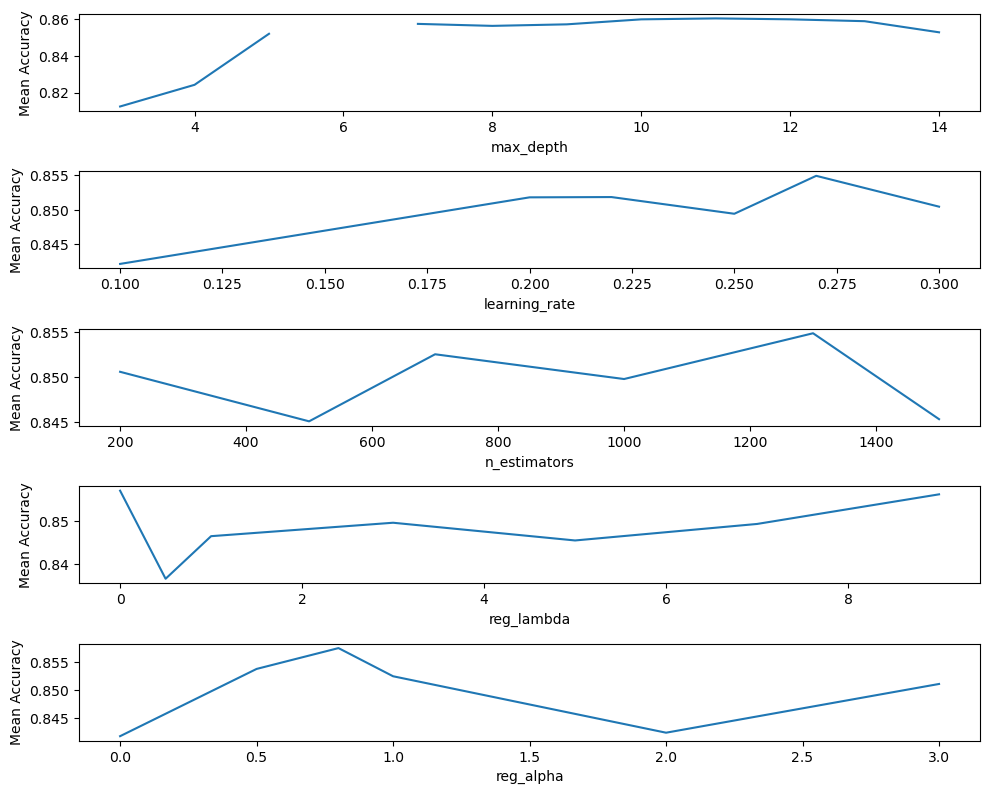

In [52]:
results = random_search.cv_results_
param_names = list(param_grid.keys())
fig, axs = plt.subplots(len(param_names), figsize=(10, 8))

for i, param_name in enumerate(param_names):
    param_values = param_grid[param_name]
    mean_scores = np.zeros(len(param_values))

    for j, param_value in enumerate(param_values):
        indices = np.where(results['param_' + param_name] == param_value)[0]
        mean_scores[j] = np.mean(results['mean_test_score'][indices])

    axs[i].plot(param_values, mean_scores)
    axs[i].set_xlabel(param_name)
    axs[i].set_ylabel('Mean Accuracy')

plt.tight_layout()
plt.show()

# Final testing
After deciding on XGBClassifier as our model, testing several preprocessing methods and deciding to go with the original dataset and finally picking the best hyper parameters we found, we are ready to test our model on the test dataset which it has never seen before.

In [53]:
xgb_final_model = XGBClassifier(**best_params)
xgb_final_model.fit(X_train_val, y_train_val)
predY = xgb_final_model.predict(X_test)
accuracy_score = accuracy_score(y_test, predY)
f1_score = f1_score(y_test, predY, average='weighted')
print(f"Accuracy score: {accuracy_score}")
print(f"F1 weighted score: {f1_score}")

Accuracy score: 0.8636027235050325
F1 weighted score: 0.8555623253211695


Our final model is has the accurcy of 86.36% over the test data.